# More Naive Bayes in Scikit-Learn: Categorical vs. Continuous Features

- We have `CategoricalNB` for categorical features
- We have `GaussianNG` for continuous features
- But no estimator that naturally applies to mixed features!

We'll demonstrate two methods to combine categorical and continuous features

1. Estimate two separate models, multipliply probabilites + normalize
2. Bin/bucketize continuous variables to categorical, estimate single categorical model

In [1]:
#Some libraries
#####

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

In [2]:
#We'll use the following dataset, it's actually not the greatest for this, but that's okay!
#Predict presence of diabetes...
##########

#df = pd.read_csv('Data/diabetes_prediction_dataset.csv')
df = pd.read_csv('https://raw.githubusercontent.com/seikenberry1/ML_Course/main/Lectures/Data/diabetes_prediction_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
#Confirm we have no NaNs:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### Define a couple functions that we'll use repeatedly

In [4]:
#Just a simple ROC Curve
####
def plot_roc(y_truth, y_prob):

    from sklearn.metrics import roc_curve

    FPR, TPR, thresholds = roc_curve(y_truth, y_prob)


    fig1, ax1 = plt.subplots(1, 1, figsize=(7,6))

    ax1.step(FPR, TPR, linewidth=2)
    ax1.plot([0,1], [0,1], '--', color = 'black')

    fs = 12
    ax1.set_xlabel('1 - Specifity = 1 - TNR = FPR', fontsize=fs)
    ax1.set_ylabel('Sensitivity = TPR', fontsize=fs)
    ax1.tick_params(axis='both', labelsize=fs)

    AUC = np.trapz(TPR, FPR)
    ax1.set_title('ROC Curve, AUC = ' + str(round(AUC,4)))

    print('AUC = ' + str(round(AUC,4)))

In [5]:
#And precision-recall:
######
def plot_pr(y_truth, y_prob):
    from sklearn.metrics import precision_recall_curve

    precisions, recalls, thresholds = precision_recall_curve(y_truth, y_prob)

    fig1, ax1 = plt.subplots(1, 1, figsize=(7,6))

    ax1.step(recalls, precisions, linewidth=2)
    ax1.grid()

    #Axis labels, etc.
    fs = 12
    ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
    ax1.set_ylabel('Precision (PPV)', fontsize=fs)
    ax1.tick_params(axis='both', labelsize=fs)

    ax1.set_title('Precision-Recall Curve')
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])


In [6]:
def report_metrics(y_truth, y_pred):

    from sklearn import metrics

    cm = metrics.confusion_matrix(y_truth, y_pred)

    print(metrics.classification_report(y_truth, y_pred))

    #Sensitivity = TPR = TP / (TP + FN)
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
    print('Sensitivity = ', sensitivity)

    #Specifity = TNR = TN / (TN + FP)
    specifity = cm[0,0] / (cm[0,0] + cm[0,1])
    print('Specifity = ', specifity)


### Just the Continuous Variables:

- Since `HbA1c_level` and `blood_glucose_level` are basically diabetes-defining, let's just use `bmi` as our single continuous predictor:

In [8]:
#df = pd.read_csv('Data/diabetes_prediction_dataset.csv')
df = pd.read_csv('https://raw.githubusercontent.com/seikenberry1/ML_Course/main/Lectures/Data/diabetes_prediction_dataset.csv')
#df = df.drop(columns = ['gender', 'hypertension', 'smoking_history', 'heart_disease',
#                        'HbA1c_level', 'blood_glucose_level', 'age'])

df = df[['bmi', 'diabetes']]

In [9]:
#Test/train split:
######

from sklearn.model_selection import train_test_split

X_train_continuous, X_test_continuous, y_train, y_test = train_test_split(df[df.columns.difference(['diabetes'])],
                                                                           df[['diabetes']], test_size=.3, random_state=42)
X_train_continuous

,bmi
76513,27.32
60406,27.32
27322,27.32
53699,27.32
65412,20.98
...,...
6265,32.98
54886,28.10
76820,26.14
860,24.96


In [10]:
#Make the GaussianNB estimator:
######

from sklearn.naive_bayes import GaussianNB

#Create
gnb = GaussianNB()

#And fit:
gnb.fit(X_train_continuous, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [11]:
#Predictions using Gaussian NB
########

y_pred_continuous = gnb.predict(X_test_continuous)

In [12]:
#Our metrics for performance?
#######

report_metrics(y_test['diabetes'], y_pred_continuous)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     27453
           1       0.29      0.07      0.11      2547

    accuracy                           0.91     30000
   macro avg       0.60      0.53      0.53     30000
weighted avg       0.87      0.91      0.88     30000

Sensitivity =  0.0691009030231645
Specifity =  0.9843368666448111


AUC = 0.7123


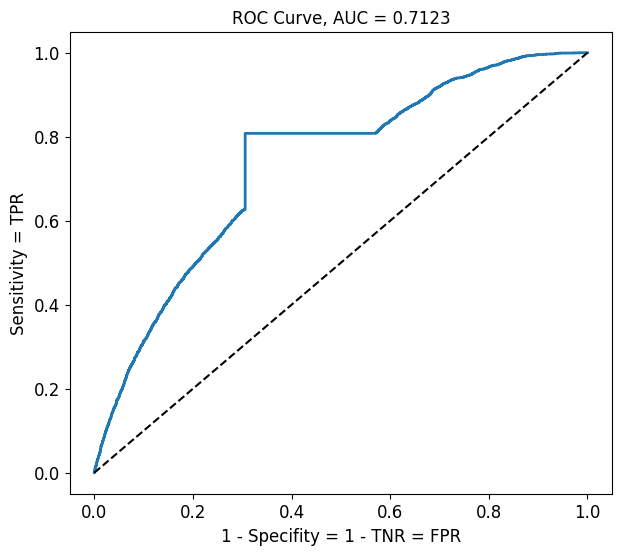

In [13]:
## ROC Curve:
#########

y_probas_continuous = gnb.predict_proba(X_test_continuous)

plot_roc(y_test, y_probas_continuous[:,1])

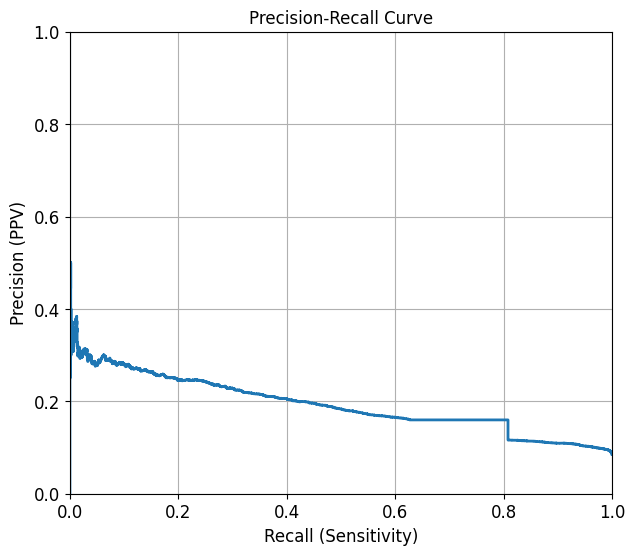

In [14]:
## And Precision-Recall

plot_pr(y_test, y_probas_continuous[:,1])

## Just the Categorical

- Use `CategoricalNB`

In [15]:
#Grab our data again
#df = pd.read_csv('Data/diabetes_prediction_dataset.csv')
df = pd.read_csv('https://raw.githubusercontent.com/seikenberry1/ML_Course/main/Lectures/Data/diabetes_prediction_dataset.csv')

df = df[['gender', 'hypertension', 'smoking_history', 'diabetes', 'heart_disease']]

#And split:
X_train_cat, X_test_cat, y_train, y_test = train_test_split(df[df.columns.difference(['diabetes'])],
                                                            df[['diabetes']], test_size=.3, random_state=42)


In [16]:
#Let's just do a quick one-hot encoding:
########

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

#Fit:
cat_encoder.fit(X_train_cat)


#And transform training data:
#####
prepared_data = cat_encoder.transform(X_train_cat)

#And put into DataFrame:
#######

X_train_prepared_cat = pd.DataFrame(prepared_data,
                         columns = cat_encoder.get_feature_names_out(),
                         index = X_train_cat.index)

X_train_prepared_cat

,gender_Female,gender_Male,gender_Other,heart_disease_0,heart_disease_1,hypertension_0,hypertension_1,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
76513,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60406,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27322,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
53699,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65412,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
54886,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
76820,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
##Also, testing data:
#######

#Use transform, NOT fit_transform!
prepared_data = cat_encoder.transform(X_test_cat)

X_test_prepared_cat = pd.DataFrame(prepared_data,
                         columns = cat_encoder.get_feature_names_out(),
                         index = X_test_cat.index)



In [18]:
## Now, for the CategoricalNB:
################3

from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()

#Fit
clf.fit(X_train_prepared_cat, y_train['diabetes'])

#Predict on *testing* data
y_pred_cat = clf.predict(X_test_prepared_cat)

In [19]:
## Metrics?

report_metrics(y_test['diabetes'], y_pred_cat)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27453
           1       0.31      0.31      0.31      2547

    accuracy                           0.88     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.88      0.88      0.88     30000

Sensitivity =  0.30624263839811544
Specifity =  0.9362911157250574


AUC = 0.7235


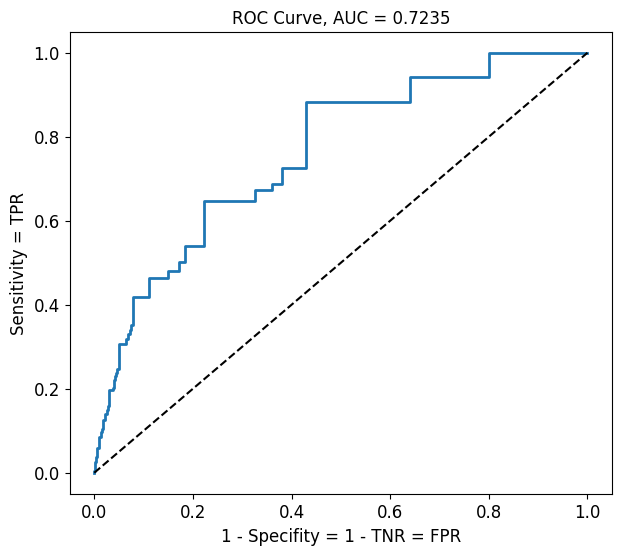

In [20]:
## ROC Curve

y_probas_cat = clf.predict_proba(X_test_prepared_cat)

plot_roc(y_test, y_probas_cat[:,1])

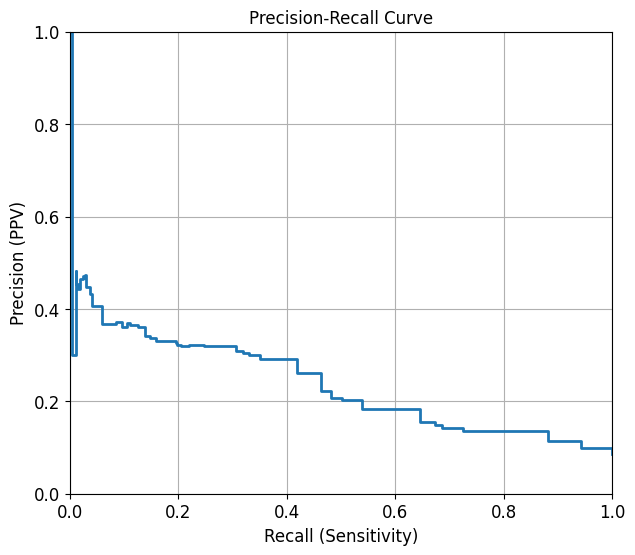

In [21]:
## And Precision-Recall
plot_pr(y_test, y_probas_cat[:,1])

# Combine Both: Option 1

- We can just combine the probabilities from the continuous and categorical models, since we assume conditional independence for our features.

- Normalize our probabilities.

In [22]:
#Get the prior probability of each category, in the training data:
values, counts = np.unique(y_train['diabetes'], return_counts=True)

#Store as Pc
Pc = counts / counts.sum()
Pc

array([0.91495714, 0.08504286])

In [23]:
#Combine the two probability vectors from above
#Also divide out the redundant
y_probas_both = y_probas_cat * y_probas_continuous / Pc

In [24]:
#Basically sum to 1
np.sum(y_probas_both, axis=1)[:10]

array([1.04144379, 1.04114051, 0.97991895, 1.02608705, 0.91929926,
       1.01991017, 1.01152982, 1.02169193, 1.02169193, 0.99929303])

In [25]:
#Ensure normalized:
#######

y_probas_both = np.divide(y_probas_both, np.sum(y_probas_both, axis=1).reshape(-1,1))

In [26]:
#Now:
np.sum(y_probas_both, axis=1)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

AUC = 0.7801


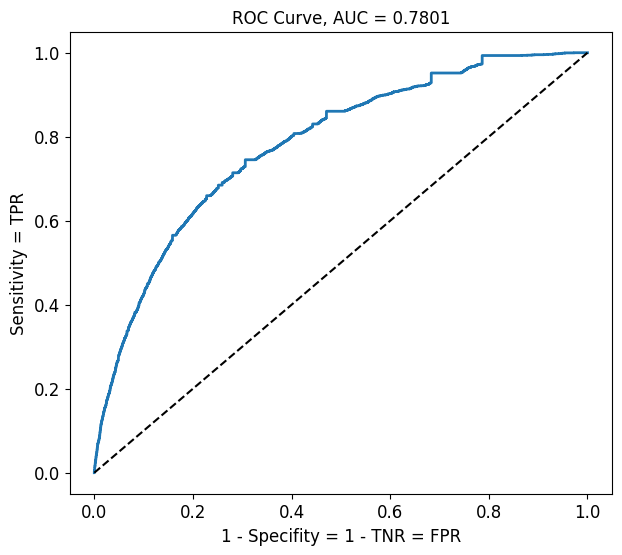

In [27]:
#ROC Curve:
#####

plot_roc(y_test, y_probas_both[:,1])

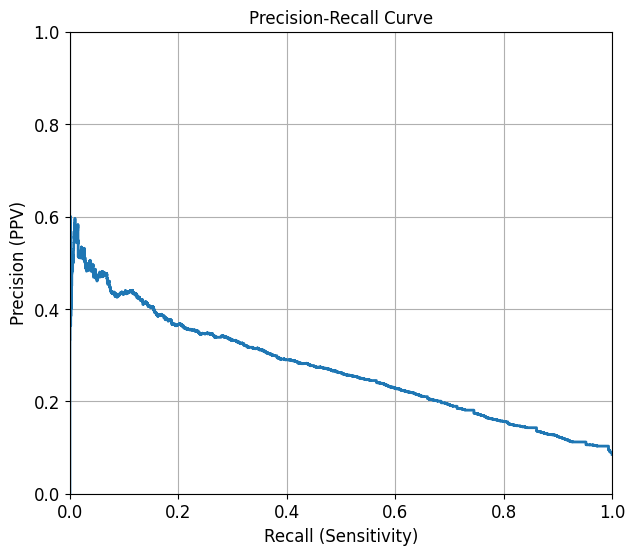

In [28]:
## And Precision-Recall
plot_pr(y_test, y_probas_both[:,1])

In [29]:
#Convert to binary prediction:
#####

y_pred_both = (y_probas_both[:,1] > 0.5).astype(int)
y_pred_both

array([0, 0, 0, ..., 1, 0, 0])

In [30]:
report_metrics(y_test['diabetes'], y_pred_both)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27453
           1       0.33      0.31      0.32      2547

    accuracy                           0.89     30000
   macro avg       0.63      0.63      0.63     30000
weighted avg       0.88      0.89      0.89     30000

Sensitivity =  0.31252453867294855
Specifity =  0.9404072414672349


In [31]:
##Recall, compare to:
report_metrics(y_test['diabetes'], y_pred_continuous)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     27453
           1       0.29      0.07      0.11      2547

    accuracy                           0.91     30000
   macro avg       0.60      0.53      0.53     30000
weighted avg       0.87      0.91      0.88     30000

Sensitivity =  0.0691009030231645
Specifity =  0.9843368666448111


In [32]:
##Recall, compare to:
report_metrics(y_test['diabetes'], y_pred_cat)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27453
           1       0.31      0.31      0.31      2547

    accuracy                           0.88     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.88      0.88      0.88     30000

Sensitivity =  0.30624263839811544
Specifity =  0.9362911157250574


# Combine Both: Option 2

- Bin our continuous data
- Convert to categorical

In [33]:
## Reload the data:
#df = pd.read_csv('Data/diabetes_prediction_dataset.csv')
df = pd.read_csv('https://raw.githubusercontent.com/seikenberry1/ML_Course/main/Lectures/Data/diabetes_prediction_dataset.csv')

df = df.drop(columns = ['HbA1c_level', 'blood_glucose_level', 'age'])

In [34]:
#Make a train-test split:
###

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[df.columns.difference(['diabetes'])], df[['diabetes']], test_size=.3, random_state=42)
X_train

,bmi,gender,heart_disease,hypertension,smoking_history
76513,27.32,Male,0,0,ever
60406,27.32,Male,0,0,never
27322,27.32,Female,0,0,current
53699,27.32,Female,0,0,current
65412,20.98,Male,0,0,No Info
...,...,...,...,...,...
6265,32.98,Male,0,0,never
54886,28.10,Female,0,0,never
76820,26.14,Male,0,0,never
860,24.96,Female,0,0,never


In [35]:
##Let's make a custom transformer:
#########

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

class QuantileBucketer(BaseEstimator, TransformerMixin):
    def __init__(self, num_quantiles=10, random_state=42):
        self.num_quantiles = num_quantiles
        self.random_state = random_state

    def fit(self, X, y=None):
        #Extract feature names from columns:
        if (isinstance(X, pd.DataFrame)):
            self.feature_names = np.array(X.columns)
        #If no columns, just 0 through n
        else:
            self.feature_names = np.array(range(0, X.shape[1])).astype(str)


        #Bucketize the data

        X = check_array(X)

        #Go through each column:
        #Will have list of lists for the bins:
        self.bins_ = [] #np.zeros([np.shape(X)[0], self.num_quantiles_

        for i in range(np.shape(X)[1]):
            X_bucket, bins = pd.qcut(X[:,i],
                                 q=self.num_quantiles, labels=False, retbins=True, duplicates='drop')

            #Need to ensure that every bin gets at least one member
            #We could do this, but we might get errors with the testing data
            #bins = [-np.inf] + list(bins) + [np.inf]

            #So let's do this instead:
            bins[0] = -np.inf
            bins[len(bins)-1] = np.inf

            self.bins_.append(bins)

        return self #Always return self

    #Transform
    def transform(self, X):

        X = check_array(X)

        for i in range(np.shape(X)[1]):
            X[:, i] = pd.cut(X[:,i], bins=self.bins_[i], labels=False)

        #Return bucketized X:
        return X


    def get_feature_names_out(self, names=None):
        #Just return the feature names used to create:
        return self.feature_names


In [36]:
#Make our binner:
bucket = QuantileBucketer(num_quantiles=10)

#No 'HbA1c_level', #blood_glucose_level #'age', just bmi:
pred_cols = ['bmi']

#Fit
bucket.fit(X_train[pred_cols])


#Try it out:
X_train_bucket = X_train.copy()
X_train_bucket[pred_cols] = bucket.transform(X_train[pred_cols])

In [37]:
#Our bins?
bucket.bins_

[array([ -inf, 19.18, 22.4 , 24.88, 27.17, 27.32, 28.28, 31.1 , 35.42,
          inf])]

In [38]:
#Our new bmi column?
X_train_bucket.bmi

76513    4.0
60406    4.0
27322    4.0
53699    4.0
65412    1.0
        ... 
6265     7.0
54886    5.0
76820    3.0
860      3.0
15795    5.0
Name: bmi, Length: 70000, dtype: float64

In [39]:
#Most common BMI?
values, counts = np.unique(X_train['bmi'], return_counts=True)

#Max value?
print(values[np.argmax(counts)])

#How many?
#Whoa! Must have been some imputation
print(counts[np.argmax(counts)])

27.32
17801


In [40]:
#Check the median?
#Yep...
np.median(X_train['bmi'])

27.32

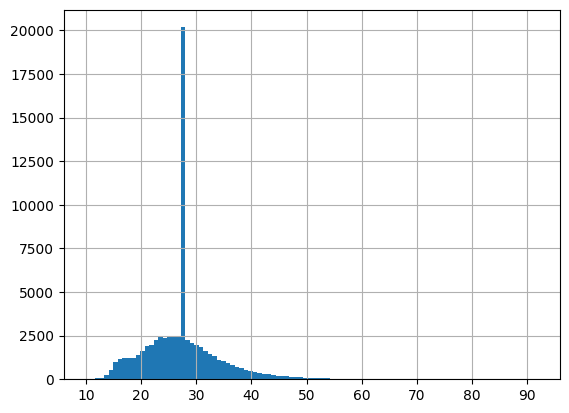

In [41]:
##Histogram
X_train.bmi.hist(bins=100);


In [42]:
#Look at our bucketed population
##
np.unique(X_train_bucket.bmi, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([ 7012,  7017,  6991,  6992, 18215,  2776,  7004,  7000,  6993]))

Text(0, 0.5, 'Number of observations')

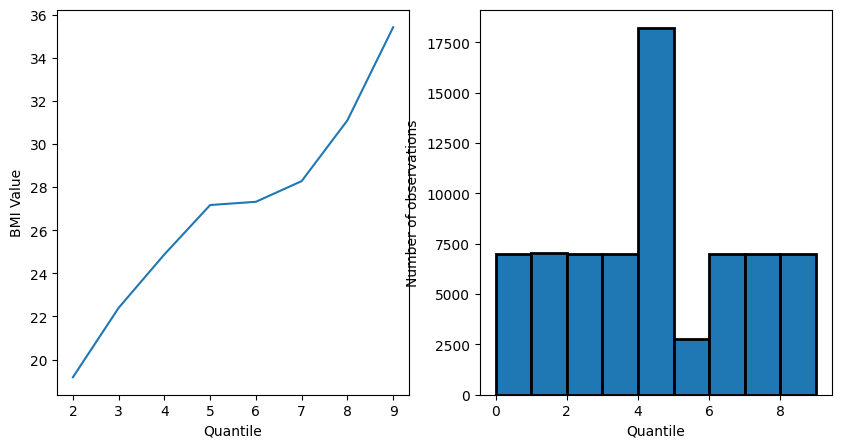

In [43]:
#Plot:
########

fig, ax1 = plt.subplots(1,2, figsize=(10,5))

#Plot the quantiles:
ax1[0].plot(range(1,len(bucket.bins_[0])+1), bucket.bins_[0])
ax1[0].set_xlabel("Quantile")
ax1[0].set_ylabel("BMI Value")

#And the bucketized/flattened population:
X_train_bucket.bmi.hist(bins=range(0,len(bucket.bins_[0])), ax=ax1[1], linewidth=2, edgecolor='black', grid=False)
ax1[1].set_xlabel("Quantile")
ax1[1].set_ylabel("Number of observations")

### Transform with some pipelines + ColumnTransformer

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

#Make a list of the numeric attributes
#Could also list out manually
num_attribs = list(X_train.select_dtypes(include=[np.number]).columns)

#And categorical:
cat_attribs = ["gender", "hypertension", "smoking_history", "heart_disease"]


#The pipeline for numeric:
num_pipeline = make_pipeline(
    QuantileBucketer(num_quantiles=10))

#And categorical:
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False))

#Our preprocessing transformer:
########
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('quantilebucketer',
                                                  QuantileBucketer())]),
                                 ['bmi', 'heart_disease', 'hypertension']),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'hypertension', 'smoking_history',
                                  'heart_disease'])])

In [45]:
#Run fit_transform on the training data
####
prepared_data = preprocessing.fit_transform(X_train)


#And put into DataFrame:
#######

X_train_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_train.index)

X_train_prepared.head()

,num__bmi,num__heart_disease,num__hypertension,cat__gender_Female,cat__gender_Male,cat__gender_Other,cat__hypertension_0,cat__hypertension_1,cat__smoking_history_No Info,cat__smoking_history_current,cat__smoking_history_ever,cat__smoking_history_former,cat__smoking_history_never,cat__smoking_history_not current,cat__heart_disease_0,cat__heart_disease_1
76513,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60406,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
27322,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
53699,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
65412,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
##Prep the test data too:

#As always, use transform, not fit_transform!
prepared_data = preprocessing.transform(X_test)

X_test_prepared = pd.DataFrame(prepared_data,
                         columns = preprocessing.get_feature_names_out(),
                         index = X_test.index)

X_test_prepared.head()

,num__bmi,num__heart_disease,num__hypertension,cat__gender_Female,cat__gender_Male,cat__gender_Other,cat__hypertension_0,cat__hypertension_1,cat__smoking_history_No Info,cat__smoking_history_current,cat__smoking_history_ever,cat__smoking_history_former,cat__smoking_history_never,cat__smoking_history_not current,cat__heart_disease_0,cat__heart_disease_1
75721,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
80184,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19864,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
76699,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
92991,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Now, the categorical model:

In [47]:
from sklearn.naive_bayes import CategoricalNB

#Create
clf = CategoricalNB()

#fit
clf.fit(X_train_prepared, y_train['diabetes'])

CategoricalNB()

In [48]:
#Predictions:
y_pred = clf.predict(X_test_prepared)

In [49]:
#Metrics, again:
report_metrics(y_test['diabetes'], y_pred)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     27453
           1       0.33      0.30      0.31      2547

    accuracy                           0.89     30000
   macro avg       0.63      0.62      0.63     30000
weighted avg       0.88      0.89      0.89     30000

Sensitivity =  0.29603455045151156
Specifity =  0.943503442246749


In [50]:
#Vs Method 1:
#report_metrics(y_test['diabetes'], y_pred_both)

AUC = 0.7818


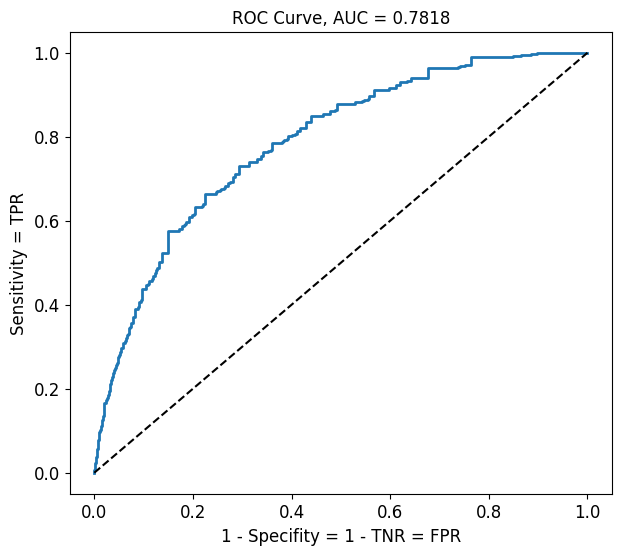

In [51]:
#And ROC Curve:
y_probas = clf.predict_proba(X_test_prepared)

plot_roc(y_test, y_probas[:,1])

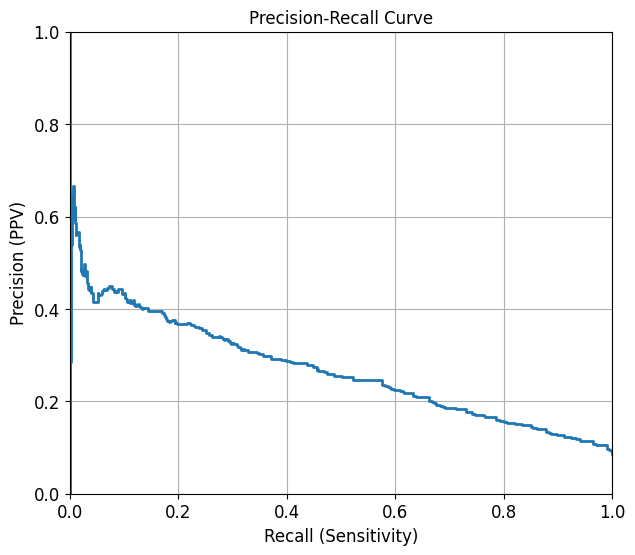

In [52]:
plot_pr(y_test, y_probas[:,1])